In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import itertools
import numpy as np
import infomap
from infomap import Infomap
from sklearn.metrics.cluster import normalized_mutual_info_score
from utils import *

# LFR Graph community detection. 
#####  Import LFR benchmark network “Benchmark graphs for testing community detection algorithms”, Andrea Lancichinetti, Santo Fortunato, and Filippo Radicchi, Phys. Rev. E 78, 046110 2008


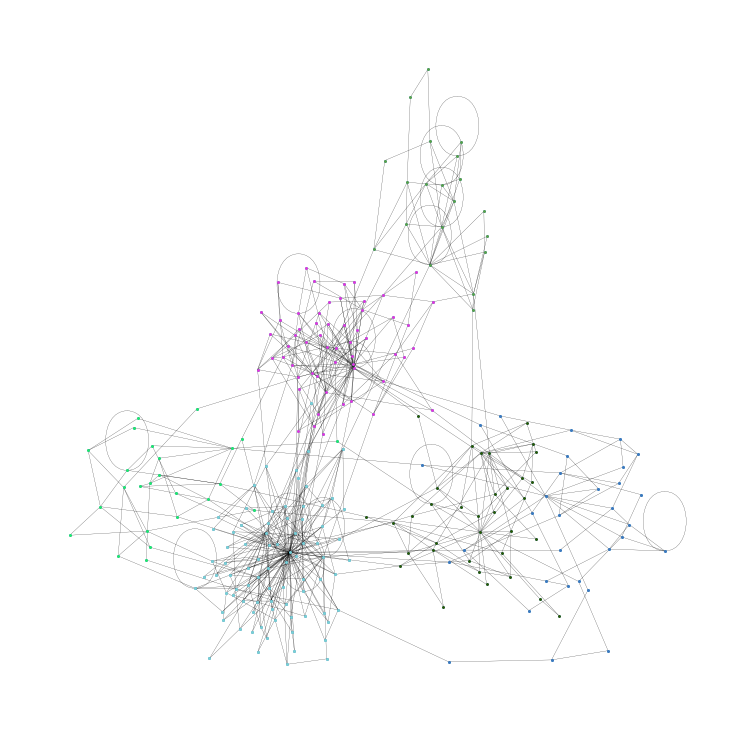

The ground truth modularity is 0.668
6 communities detected


In [2]:
n = 250 # Number of nodes in the created graph.
tau1 = 2.5 # Power law exponent for the degree distribution of the created graph. 
tau2 = 1.5 # Power law exponent for the community size distribution in the created graph.
mu = 0.1 # Fraction of inter-community edges incident to each node. 

G = nx.LFR_benchmark_graph( n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10) 
# Get ground truth communities


ground_truth_communities = list({frozenset(G.nodes[v]["community"]) for v in G})
presentCommunities(G,ground_truth_communities)
# Use modularity to check partition
ground_truth_mod = nx_comm.modularity(G,ground_truth_communities)
print(f"The ground truth modularity is {ground_truth_mod:.3}")
print(f"{len(ground_truth_communities)} communities detected")


ground_truth_communites_vector = NMI_reshape(ground_truth_communities,n)




# Girvan Newman 
##### Invesitigate how modularity changes as more disconections are made and more communities are found

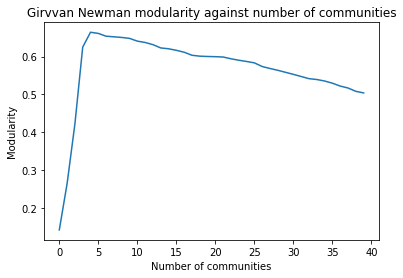

CPU times: user 10.8 s, sys: 50.7 ms, total: 10.8 s
Wall time: 10.7 s


In [3]:
%%time
# Algorithm 1. Girvan Newman 
partition_girvan_newman = girvan_newman(G)
k = 40 # Check 39 partitions

mod_list = []
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)
    # Use modularity to check partition
    GN_mod = nx_comm.modularity(G,partitions)
    mod_list.append(GN_mod)

# plot partitions with k to optimize modularity
plt.plot(mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Girvvan Newman modularity against number of communities")
plt.show()

##### Check modularity with apriori knowledge of 6 communities from the ground truth

6 communities detected
The modularity is 0.664


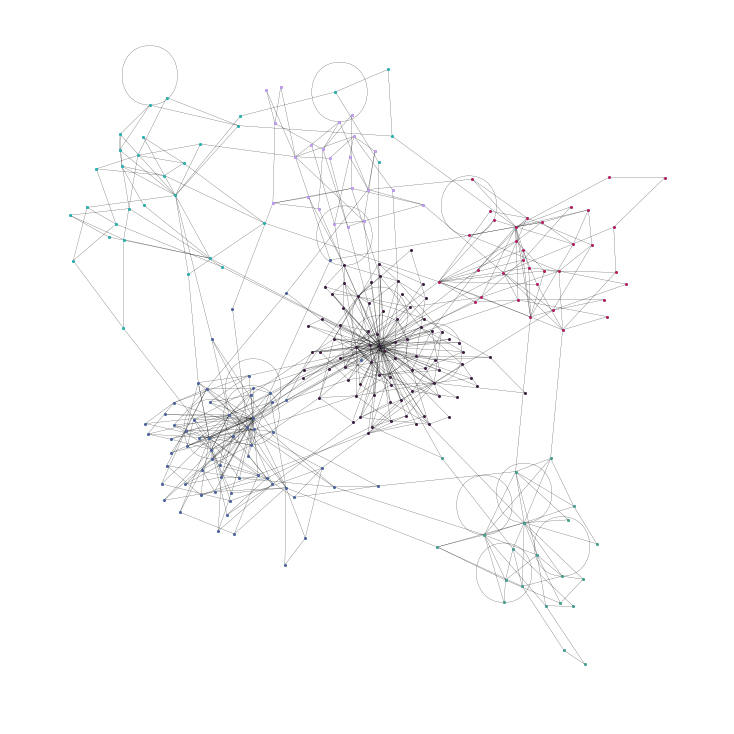

CPU times: user 5.94 s, sys: 120 ms, total: 6.06 s
Wall time: 5.77 s


In [4]:
%%time 
partition_girvan_newman = girvan_newman(G)
k=5 # if we have apriori knowledge of 3 groudn truth communities:
for communities in itertools.islice(partition_girvan_newman, k):
    GN_partitions = tuple(sorted(c) for c in communities)


GN_mod = nx_comm.modularity(G,GN_partitions)
print(f"{len(GN_partitions)} communities detected")
print(f"The modularity is {GN_mod:.3}")
presentCommunities(G,GN_partitions)


GN_partitions_vector = NMI_reshape(GN_partitions,n)
GN_NMI = normalized_mutual_info_score(ground_truth_communites_vector,GN_partitions_vector)


# Infomap
#####  https://github.com/mapequation/infomap

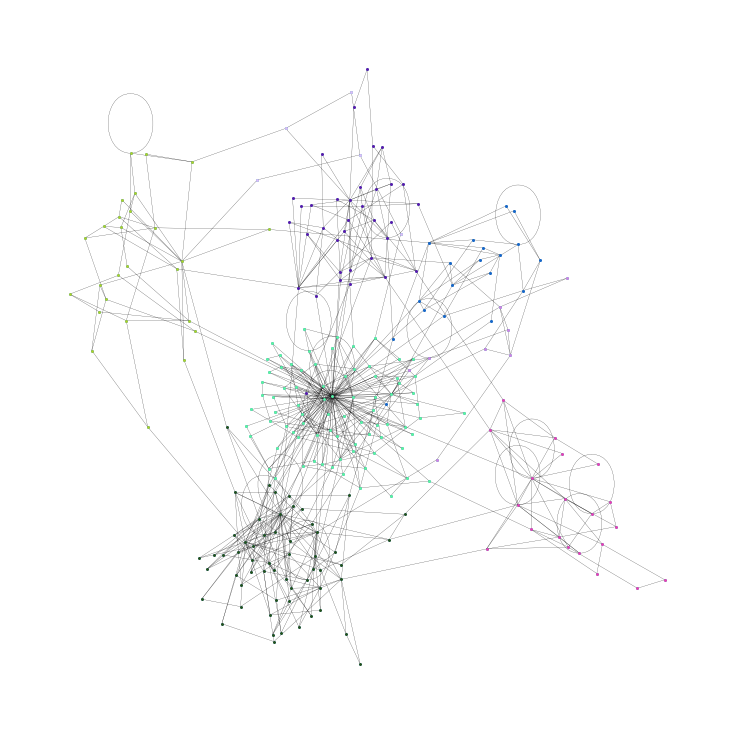

8 communities detected
The modularity is 0.661
CPU times: user 798 ms, sys: 132 ms, total: 930 ms
Wall time: 312 ms


In [5]:
%%time
# Algorithm 2. k infomap

im = Infomap(silent=True)
im.add_networkx_graph(G)
im.run()

infomap_partition = [[] for _ in range(im.num_top_modules)]
for node in im.tree:
    if node.is_leaf:
        infomap_partition[node.module_id-1].append(node.node_id)

# Need to decide when to stop removing edges.
presentCommunities(G,infomap_partition)

info_mod = nx_comm.modularity(G,tuple(infomap_partition))
print(f"{len(infomap_partition)} communities detected")
print(f"The modularity is {info_mod:.3}")


infomap_partitions_vector = NMI_reshape(infomap_partition,n)
infomap_NMI = normalized_mutual_info_score(ground_truth_communites_vector,infomap_partitions_vector)

# Spectral Clustering

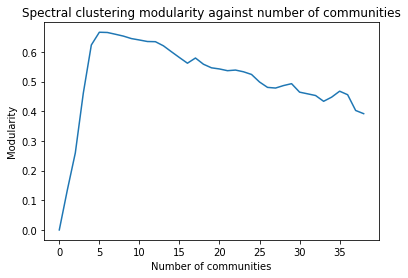

CPU times: user 1min 24s, sys: 55.3 s, total: 2min 20s
Wall time: 31.7 s


In [6]:
%%time
# Algorithm 3. Spectral clustering

# Get adjacency-matrix as numpy-array
sc_mod_list = []
for k in range(1,40):
    adj_mat = nx.to_numpy_matrix(G)
    # Cluster
    sc = SpectralClustering(k, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    partition_labels = sc.labels_.tolist()
    # Turn back into partition data structure ([],[],[]...)
    # position in list is node number value is community id

    partition = [[] for _ in range(max(partition_labels)+1)]
    for idx,c in enumerate(partition_labels):
        partition[c].append(idx)

    sc_mod = nx_comm.modularity(G,tuple(partition))
    sc_mod_list.append(sc_mod)

# Plot modularity for increasing community number
plt.plot(sc_mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Spectral clustering modularity against number of communities")
plt.show()

##### With apriori knowledge of ground truth community number k = 3

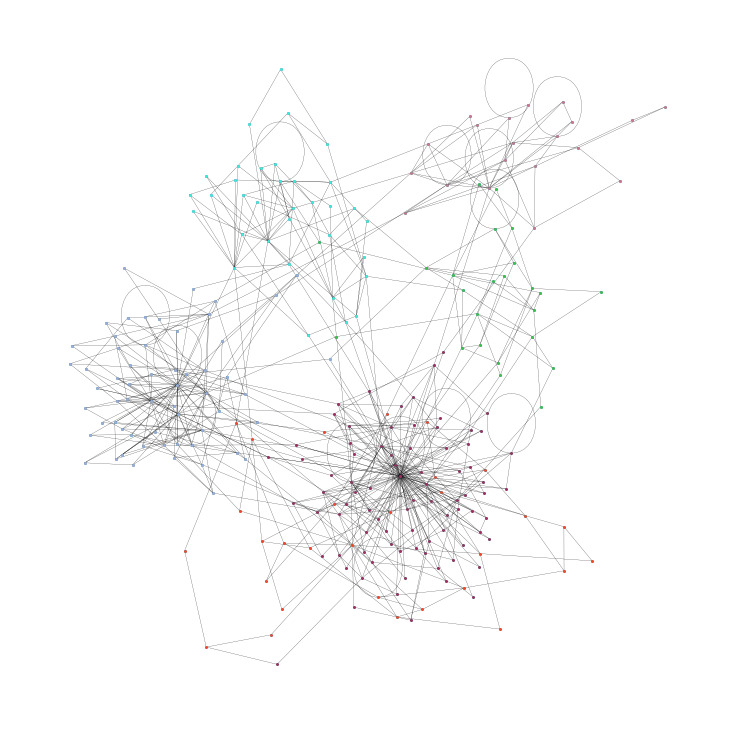

6 communities detected
The modularity is 0.666
CPU times: user 936 ms, sys: 461 ms, total: 1.4 s
Wall time: 484 ms


In [7]:
%%time
k=6
# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G)
# Cluster
sc = SpectralClustering(k, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

partition_labels = sc.labels_.tolist()
# Turn back into partition data structure ([],[],[]...)
# position in list is node number value is community id

sc_partition = [[] for _ in range(max(partition_labels)+1)]
for idx,c in enumerate(partition_labels):
    sc_partition[c].append(idx)

# Need to decide when to stop removing edges.
presentCommunities(G,sc_partition)

sc_mod = nx_comm.modularity(G,tuple(sc_partition))
print(f"{len(sc_partition)} communities detected")
print(f"The modularity is {sc_mod:.3}")

sc_partition_vector = NMI_reshape(sc_partition,n)
sc_NMI = normalized_mutual_info_score(ground_truth_communites_vector,sc_partition_vector)

# Analysis

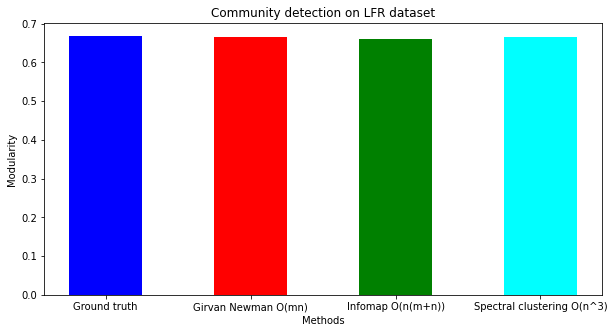

In [8]:
# Compare methods
data = {'Ground truth':ground_truth_mod, 'Girvan Newman O(mn)':GN_mod, 'Infomap O(n(m+n))':info_mod,
        'Spectral clustering O(n^3)':sc_mod}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['blue', 'red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("Modularity")
plt.title("Community detection on LFR dataset")
plt.show()

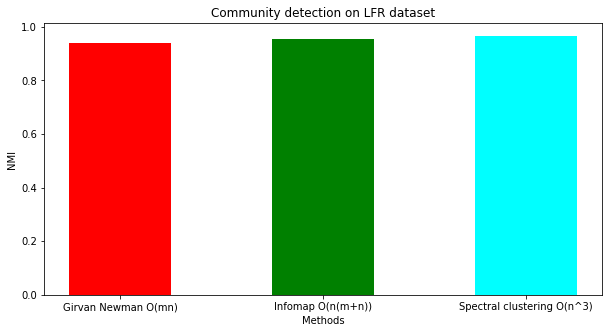

In [9]:
# Compare methods
data = {'Girvan Newman O(mn)':GN_NMI, 'Infomap O(n(m+n))':infomap_NMI,
        'Spectral clustering O(n^3)':sc_NMI}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("NMI")
plt.title("Community detection on LFR dataset")
plt.show()

In [10]:
# chenge mu and plot for each mu Normalised mutual information 
# chenge mu and plot for each mu Q (modularity)

# Define loop for runs



# n_list = [100,1000,10000] # sizes of graphs to compare.
# for n in n_list:
#     for mu in range(0,1,0.1):
#         G = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10) 

#         # Method of community detection
#         communities = method1(G)
#         community_list = 
#         # change representation to list...

#         NMI = normalized_mutual_info_score[community_listcommunity_list,G]

#         Q = nx_comm.modularity(G,communities)
#         Q_list.append(Q)
#         NMI_list.append(NMI)
        # Pack data for later presentation

# save data as pickle



